In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches
import warnings
warnings.filterwarnings('ignore')
import os

C:\Users\DELL\AppData\Local\Temp\ipykernel_11204\3776833915.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
os.chdir("C:\\Users\\HP\\Desktop\\my work")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\HP\\Desktop\\my work'

In [3]:
df = pd.read_csv("ab_test_click_data (1).csv")
df= df.drop("timestamp", axis=1)
print(df.describe())

            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000


In [29]:
print(df['click'].value_counts().reset_index())
print(df.head())
# click by group
print(df.groupby('group')['click'].sum().reset_index())

   click  count
0      0  11895
1      1   8105
   user_id  click group
0        1      1   exp
1        2      0   exp
2        3      1   exp
3        4      0   exp
4        5      1   exp
  group  click
0   con   1989
1   exp   6116


A simple bar chart showing the total click versus no-clicks in each group

In [1]:

palette = {0:'green', 1:'black'}
labels=['yes', 'no']
plt.figure(figsize=[10,10])
ax = sns.catplot(data=df, x='group', kind='count', hue='click',
                palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.legend(title='click', labels=['no', 'yes'])

#calcuating percantages and annotate the bars
group_counts = df.groupby(['group']).size()
group_click_counts = df.groupby(['group','click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    #find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc['group']
    percentage = 100*height / total 
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [40]:
print(group_click_counts)

  group  click     0
0   con      0  8011
1   con      1  1989
2   exp      0  3884
3   exp      1  6116


##### Parameters of the Model from power analysis
    - β: probability of type II error
    - (1-β): power of the test
    - α: probability of type I error <significance level> we want to compare our p-value to.
    - δ: Minimum detectable effect
    

In [80]:
alpha = 0.05
delta = 0.1

##### Calculating total number of clicks per group by summing clicks

In [72]:
X_ = df.groupby('group')['click'].sum().reset_index()
X_con = df.groupby('group')['click'].sum().loc['con']
X_exp = df.groupby('group')['click'].sum().loc['exp']
print('num of clicks in control = ',X_con)
print('num of clicks in experiment = ',X_exp)

#total number per group
N_con = df['group'].value_counts().loc['con']
N_exp = df['group'].value_counts().loc['exp']
print('num of users in control = ',N_con)
print('num of users in experiment = ',N_exp)

num of clicks in control =  1989
num of clicks in experiment =  6116
num of users in control =  10000
num of users in experiment =  10000


##### Calculating pooled Estimates for clicks per group

In [75]:
# computing the estimates of click probability per group
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click probability in Control Group: ", p_con_hat)
print("Click probability in Control Group: ", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click probability = ", p_pooled_hat)

Click probability in Control Group:  0.1989
Click probability in Control Group:  0.6116
Pooled Click probability:  0.40525


##### Calculating Pooled Variance

In [76]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("pooled variance = ", pooled_variance)

pooled variance =  4.82044875e-05


##### Calculating Standard Error and Test Statistics

In [82]:
#Standard error
SE = np.sqrt(pooled_variance)
print('Standard Error = ', SE)

# computing the test statistics of Z-test
test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test = ", test_stat)

# critical value of the Z-test
z_crit = norm.ppf(1-alpha/2)
print('Z-critical value from standard normal distribution = ', z_crit)

Standard Error =  0.006942945160376826
Test Statistics for 2-sample Z-test =  -59.44163326469381
Z-critical value from standard normal distribution =  1.959963984540054


##### Calculating p-values of Z-test
- A low p-value(p ≤ 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
- A high p-value(p > 0.05 ) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [86]:
# calculating p-value
p_value = 2*norm.sf(abs(test_stat))

def is_statistical_significance(p_value, alpha):
    #print the rounded p-value to 3 decimal places
    print(f"p-value of 2-sample Z-test = {round(p_value, 3)}")

    #determine statistical significance
    if p_value <= alpha:
        print('There is a statistical significance, indicating that the observed difference between the groups are unlikely to have occurred by chance alone. this suggests that new feature is better')
    else:
        print('There is no statistical significance, indicating that the observed difference between the groups could have to occurred by chance. this implies that the older version is better')

is_statistical_significance(p_value, alpha)

p-value of 2-sample Z-test = 0.0
There is a statistical significance, indicating that the observed difference between the groups are unlikely to have occurred by chance alone. this suggests that new feature is better


##### Calculating and plotting the confidence interval of the test 

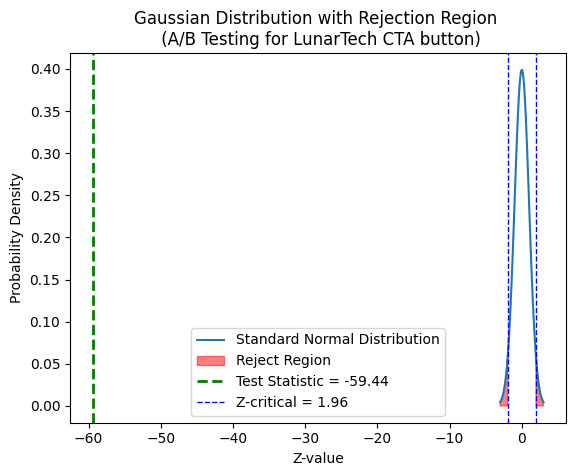

In [101]:
mu = 0 # mean
sigma = 1 # standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

#plotting the standard normal distribution
plt.plot(x,y, label='Standard Normal Distribution')

#shade the rejection region for two-tailed test
plt.fill_between(x,y, where=(x > z_crit) | (x < -z_crit), color='red', alpha=0.5, label='Reject Region')
# adding test statistic
plt.axvline(test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {test_stat:.2f}')

#adding Z-critical values
plt.axvline(z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {z_crit:.2f}')
plt.axvline(-z_crit, color='blue', linestyle='dashed', linewidth=1)
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.ylabel('Probability Density')
plt.xlabel('Z-value')
plt.legend()
plt.show()